# **Renewables Scenario Generation GAN**

Unofficial implementation in PyTorch.

Reference to the authors' work:

Y. Chen, Y. Wang, D. Kirschen and B. Zhang, "Model-Free Renewable Scenario Generation Using Generative Adversarial Networks," in IEEE Transactions on Power Systems, vol. 33, no. 3, pp. 3265-3275, May 2018, doi: 10.1109/TPWRS.2018.2794541.

https://ieeexplore.ieee.org/abstract/document/8260947

### **Import of Packages**

In [44]:
import os
import time
import csv
from itertools import chain

import numpy as np

import torch
from torch import nn, tensor

import matplotlib.pyplot as plt

### **Functions**

In [45]:
#Function from the paper, slightly edited
def load_solar_data(path_data: str(), path_labels:str()) -> tuple():
    """Load and preprocess data and labels for training the GAN model."""
    with open(f'{path_data}' if path_data.endswith('csv') else f'{path_data}.csv', 'r') as csvfile:
        rows = np.array([row for row in csv.reader(csvfile)], dtype=float)
    #Specify according to time points in your own dataset
    rows = rows[:104832,:]
    print('\nShape rows', rows.shape)

    with open(f'{path_labels}' if path_labels.endswith('csv') else f'{path_labels}.csv', 'r') as csvfile:
        labels = np.array([row for row in csv.reader(csvfile)], dtype=int)
    print('Shape labels', labels.shape)

    #Data corresponds to GAN input dimensions (24x24 = 576)
    trX = np.reshape(rows.T,(-1,576))
    print('\nShape trX',trX.shape)
    m = np.ndarray.max(rows)
    print("\nMax(Solar)", m)
    trY = np.tile(labels,(32,1))
    print('\nShape trY', trY.shape)
    trX = trX/m

    return trX, trY, m

In [46]:
def load_wind_data(path_data: str(), path_labels: str()) -> tuple():
    #Example dataset created for evnet_based GANs wind scenarios generation
    # Data from NREL wind integrated datasets
    with open(f'{path_data}' if path_data.endswith('csv') else f'{path_data}.csv', 'r') as csvfile:
        rows = np.array([row for row in csv.reader(csvfile)], dtype=float)
    trX = []
    m = np.ndarray.max(rows)
    print('\nMax(Wind)', m)
    
    for x in range(rows.shape[1]):
        train = rows[:-288, x].reshape(-1, 576)
        train = train / m

        trX.extend(train)

    trX = np.asarray(trX)
    print('\nShape TrX', trX.shape)

    with open(f'{path_labels}' if path_labels.endswith('csv') else f'{path_labels}.csv', 'r') as csvfile:
        label = np.array([row for row in csv.reader(csvfile)], dtype=int)
    print('\nShape Label', label.shape)
    
    return trX, label, m

In [47]:
def OneHot(X, n, negative_class=0.):
    """Function for encoding ordinal labels into OneHot representation."""
    X = np.asarray(X).flatten()
    if n is None:
        n = np.max(X) + 1
    Xoh = np.ones((len(X), n)) * negative_class
    for i in range(len(X)):
        m = X[i]
        Xoh[i,m] = 1
    return Xoh

### **Load Data**

In [48]:
#Load and preprocess the data and labels
trX, trY, m = load_wind_data(os.path.join('/kaggle/input/renewables-scenario-data/wind.csv'), os.path.join('/kaggle/input/renewables-scenario-data/wind label.csv'))

#Find number of unique ordinal labels in solar label.csv, each representing a distinct event
events_num = len(np.unique(trY))


Max(Wind) 16.0

Shape TrX (9464, 576)

Shape Label (9464, 1)


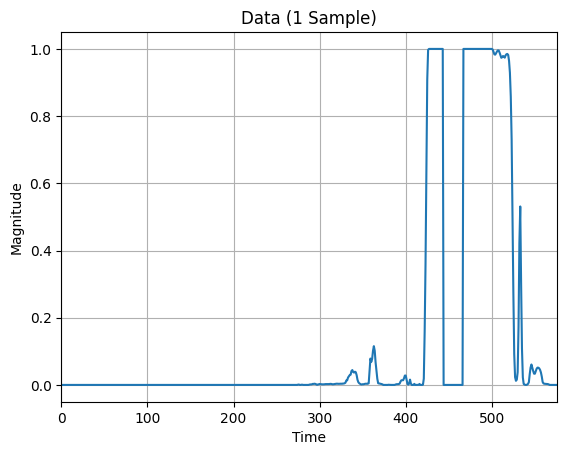

In [49]:
#Depict one sample from the data
fig, ax = plt.subplots()
ax.plot(trX[0,:])
ax.set_xlim(0, trX.shape[-1])
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude')
ax.set_title('Data (1 Sample)')
ax.grid(True)

### **Device**

In [50]:
device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu')

print('Current device:', device)

Current device: cuda


### **Generator**

In [51]:
class Generator(nn.Module):
    def __init__(self, batch_size, dim_y, dim_z, dim_W1, dim_W2, dim_W3, dim_channel):
        super().__init__()
        self.batch_size = batch_size
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.dim_W1 = dim_W1
        self.dim_W2 = dim_W2
        self.dim_W3 = dim_W3
        self.dim_channel = dim_channel
        
        self.layer1 = nn.Sequential(nn.Linear(dim_z + dim_y, dim_W1, bias=False),
                                    nn.BatchNorm1d(dim_W1, eps=1e-8),
                                    nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(dim_W1 + dim_y, dim_W2*6*6, bias=False),
                                    nn.BatchNorm1d(dim_W2*6*6, eps=1e-8),
                                    nn.ReLU())
        self.layer3 = nn.Sequential(nn.ConvTranspose2d(in_channels=dim_W2 + dim_y, out_channels=dim_W3, kernel_size=5, stride=2, padding=2, output_padding=1),
                                    nn.BatchNorm2d(dim_W3, eps=1e-8),
                                    nn.ReLU())
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(in_channels=dim_W3 + dim_y, out_channels=dim_channel, kernel_size=5, stride=2, padding=2, output_padding=1),
                                    nn.BatchNorm2d(dim_channel, eps=1e-8))

    def forward(self, z, y):
        yb = torch.reshape(y, (self.batch_size, self.dim_y, 1, 1))
        z = torch.cat((z, y), 1)
        h1 = self.layer1(z)
        h1 = torch.cat((h1, y), 1)
        h2 = self.layer2(h1)
        h2 = torch.reshape(h2, (self.batch_size, self.dim_W2, 6, 6))
        h2 = torch.cat((h2, torch.mul(yb, torch.ones((self.batch_size, self.dim_y, 6, 6), dtype=torch.float32, device=device))), 1)
        n = torch.mul(yb, torch.ones((self.batch_size, self.dim_y, 6, 6), dtype=torch.float32, device=device))
        h3 = self.layer3(h2)
        h3 = torch.cat((h3, torch.mul(yb, torch.ones((self.batch_size, self.dim_y, 12, 12), dtype=torch.float32, device=device))), 1)
        h4 = self.layer4(h3)

        return h4

### **Discriminator**

In [52]:
class Discriminator(nn.Module):
    def __init__(self, batch_size, dim_y, dim_z, dim_W1, dim_W2, dim_W3, dim_channel):
        super().__init__()
        self.batch_size = batch_size
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.dim_W1 = dim_W1
        self.dim_W2 = dim_W2
        self.dim_W3 = dim_W3
        self.dim_channel = dim_channel
        
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=dim_channel + dim_y, out_channels=dim_W3, kernel_size=5, stride=2, padding=2),
                                    nn.LeakyReLU(negative_slope=0.2, inplace=True))
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=dim_W3 + dim_y, out_channels=dim_W2, kernel_size=5, stride=2, padding=2),
                                    nn.BatchNorm2d(dim_W2, eps=1e-8),
                                    nn.LeakyReLU(negative_slope=0.2, inplace=True))
        self.layer3 = nn.Sequential(nn.Linear(dim_W2*6*6 + dim_y, dim_W1, bias=False),
                                    nn.BatchNorm1d(dim_W1, eps=1e-8),
                                    nn.LeakyReLU(negative_slope=0.2, inplace=True))

    def forward(self, image, y):
        yb = torch.reshape(y, (self.batch_size, self.dim_y, 1, 1))
        x = torch.cat((image, torch.mul(yb, torch.ones((self.batch_size, self.dim_y, 24, 24), dtype=torch.float32, device=device))), 1)
        h1 = self.layer1(x)
        h1 = torch.cat((h1, torch.mul(yb, torch.ones((self.batch_size, self.dim_y, 12, 12), dtype=torch.float32, device=device))), 1)
        h2 = self.layer2(h1)
        h2 = torch.reshape(h2, (self.batch_size, -1))
        h2 = torch.cat((h2, y), 1)
        h3 = self.layer3(h2)

        return h3

### **Cost Functions**

In [53]:
def generator_cost(raw_gen2):
    return -torch.mean(raw_gen2)

In [54]:
def discriminator_cost(raw_real2, raw_gen2):
    return torch.sum(raw_gen2) - torch.sum(raw_real2)

### **GAN**

In [55]:
class GAN(nn.Module):
    def __init__(self, epochs=10, batch_size=32, image_shape=[1, 24, 24], dim_y=6, dim_z=100, dim_W1=1024, dim_W2=128, dim_W3=64, dim_channel=1):
        super().__init__()
        self.epochs = epochs
        self.batch_size = batch_size
        self.image_shape = image_shape
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.dim_W1 = dim_W1
        self.dim_W2 = dim_W2
        self.dim_W3 = dim_W3
        self.dim_channel = dim_channel
        self.normal = (0, 0.1)

        self.generator = Generator(batch_size, dim_y, dim_z, dim_W1, dim_W2, dim_W3, dim_channel)
        self.discriminator = Discriminator(batch_size, dim_y, dim_z, dim_W1, dim_W2, dim_W3, dim_channel)

        self.optimizer_g = torch.optim.RMSprop(list(self.generator.parameters()), lr=1e-4)
        self.optimizer_d = torch.optim.RMSprop(list(self.discriminator.parameters()), lr=1e-4)

        #Initialization of weights
        for weights in chain(self.generator.parameters(), self.discriminator.parameters()):
            torch.nn.init.normal_(weights, mean=0.0, std=0.02)

        self.fitting_time = None

    def fit(self, x, y):
        self.fitting_time = time.time()
        iterations = 0
        #Control balance of training discriminator vs generator
        k = 4

        gen_loss_all = []
        p_real = []
        p_fake = []
        p_distri = []
        discrim_loss = []

        for epoch in range(self.epochs):
            if (epoch + 1) % (0.1*self.epochs) == 0:
                print('Epoch:', epoch + 1)
                
            index = np.arange(len(y))
            np.random.shuffle(index)
            x = x[index]
            y = y[index]
            y2 = OneHot(y, n=self.dim_y)

            for start, end in zip(range(0, len(y), self.batch_size), range(self.batch_size, len(y), self.batch_size)):
                xs = x [start:end].reshape([-1, 1, 24, 24])
                ys = y2[start:end]

                zs = np.random.normal(self.normal[0], self.normal[1], size=(self.batch_size, self.dim_z)).astype(np.float32)

                xs = tensor(xs, dtype=torch.float32, device=device)
                ys = tensor(ys, dtype=torch.float32, device=device)
                zs = tensor(zs, dtype=torch.float32, device=device)

                self.train()
                if iterations % k == 0:
                    self.optimizer_g.zero_grad()

                    h4 = self.generator(zs, ys)
                    image_gen = nn.Sigmoid()(h4)
                    raw_gen2 = self.discriminator(image_gen, ys)
                    p_gen_val = torch.mean(raw_gen2)

                    gen_loss_val = generator_cost(raw_gen2)

                    raw_real2 = self.discriminator(xs, ys)
                    p_real_val = torch.mean(raw_real2)

                    discrim_loss_val = discriminator_cost(raw_real2, raw_gen2)

                    gen_loss_val.backward()
                    self.optimizer_g.step()
                else:
                    self.optimizer_d.zero_grad()

                    h4 = self.generator(zs, ys)
                    image_gen = nn.Sigmoid()(h4)
                    raw_gen2 = self.discriminator(image_gen, ys)
                    p_gen_val = torch.mean(raw_gen2)

                    gen_loss_val = generator_cost(raw_gen2)

                    raw_real2 = self.discriminator(xs, ys)
                    p_real_val = torch.mean(raw_real2)

                    discrim_loss_val = discriminator_cost(raw_real2, raw_gen2)

                    discrim_loss_val.backward()
                    self.optimizer_d.step()

                p_real.append(p_real_val.cpu().item())
                p_fake.append(p_gen_val.cpu().item())
                discrim_loss.append(discrim_loss_val.cpu().item())

                if iterations % 1000 == 0:
                    print('Iterations',
                          iterations,
                          '| Average P(real)', p_real_val.cpu().item(),
                          'P(fake)', p_gen_val.cpu().item(),
                          '| Discriminator loss:', discrim_loss_val.cpu().item())
                    # print('Average P(real) =', p_real_val.cpu().item())
                    # print('Average P(gen) =', p_gen_val.cpu().item())
                    # print('Discriminator loss:', discrim_loss_val.cpu().item())

                    # self.eval()
                    # with torch.no_grad():
                    #     y_np_sample = OneHot(np.random.randint(events_num, size=[self.batch_size]), n=events_num)
                    #     z_np_sample = np.random.normal(self.normal[0], self.normal[1], size=[self.batch_size, self.dim_z]).astype(np.float32)

                    #     y_np_sample = tensor(y_np_sample, dtype=torch.float32, device=device)
                    #     z_np_sample = tensor(z_np_sample, dtype=torch.float32, device=device)

                    #     generated_samples = nn.Sigmoid()(self.generator(z_np_sample, y_np_sample))

                    #     generated_samples = generated_samples.reshape([-1, 576])
                    
                    #     generated_samples = generated_samples * max_value
                    
                        # with open(data_saving_path + '%s.csv' %iterations, 'w') as csvfile:
                        #     # spamwriter = csv.writer(csvfile, delimiter=' ', quotechar='|', quoting=csv.QUOTE_MINIMAL)
                        #     writer = csv.writer(csvfile)
                        #     writer.writerows(generated_samples.cpu().detach().numpy())
                        #     csvfile.close()

                iterations += 1

        self.fitting_time = np.round(time.time() - self.fitting_time, 3)
        print('\nElapsed Training Time: ' + time.strftime('%Hh %Mmin %Ss', time.gmtime(self.fitting_time)))

        #Plotting
        # print('P_real', p_real)
        # print('P_fake', p_fake)

        fig, ax = plt.subplots()
        ax.plot(p_real, label='real')
        ax.plot(p_fake, label='fake')
        ax.legend()
        ax.set_xlim(0, len(p_real))
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Wasserstein Distance')
        ax.grid(True)
        fig.show()

        fig, ax = plt.subplots()
        ax.plot(discrim_loss)
        ax.set_xlim(0, len(discrim_loss))
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Discriminator Loss')
        ax.grid(True)
        fig.show()

    def predict(self):
        self.eval()
        with torch.no_grad():
            y_np_sample = OneHot(np.random.randint(events_num, size=[self.batch_size]), n=self.dim_y)
            zs = np.random.normal(self.normal[0], self.normal[1], size=[self.batch_size, self.dim_z]).astype(np.float32)

            y_np_sample = tensor(y_np_sample, dtype=torch.int8, device=device)
            zs = tensor(zs, dtype=torch.float32, device=device)

            generated_samples = nn.Sigmoid()(self.generator(zs, y_np_sample))

        #Image shape 24x24 = 576
        generated_samples = generated_samples.reshape([-1, 576])

        return generated_samples.cpu().detach().numpy(), y_np_sample.cpu().detach().numpy()

        # with open(f'{path_data}' if path_data.endswith('csv') else f'{path_data}.csv', 'w') as csvfile:
        #     writer = csv.writer(csvfile)
        #     writer.writerows(generated_samples.cpu().detach().numpy())
        #     csvfile.close()

        # with open(f'{path_labels}' if path_labels.endswith('csv') else f'{path_labels}.csv', 'w') as csvfile:
        #     writer = csv.writer(csvfile)
        #     writer.writerows(y_np_sample.cpu().detach().numpy())
        #     csvfile.close()

### **Create and train Model**

In [56]:
#Set training parameters
EPOCHS = 5000

In [57]:
#Instantiate specified model
model = GAN(epochs=EPOCHS,
            dim_y=events_num).to(device)

Iterations 0 | Average P(real) 0.009123343043029308 P(fake) 0.009132820181548595 | Discriminator loss: 0.310546875
Iterations 1000 | Average P(real) 0.031789764761924744 P(fake) 0.017588261514902115 | Discriminator loss: -465.3548583984375
Iterations 2000 | Average P(real) 0.051158543676137924 P(fake) 0.029477039352059364 | Discriminator loss: -710.4595336914062
Iterations 3000 | Average P(real) 0.06831996142864227 P(fake) 0.041380688548088074 | Discriminator loss: -882.74609375
Iterations 4000 | Average P(real) 0.0913068950176239 P(fake) 0.04303887486457825 | Discriminator loss: -1581.646484375
Iterations 5000 | Average P(real) 0.10981427133083344 P(fake) 0.05538128688931465 | Discriminator loss: -1783.6600341796875
Iterations 6000 | Average P(real) 0.13174498081207275 P(fake) 0.06154513359069824 | Discriminator loss: -2300.30859375
Iterations 7000 | Average P(real) 0.15336620807647705 P(fake) 0.07389532029628754 | Discriminator loss: -2604.10205078125
Iterations 8000 | Average P(real

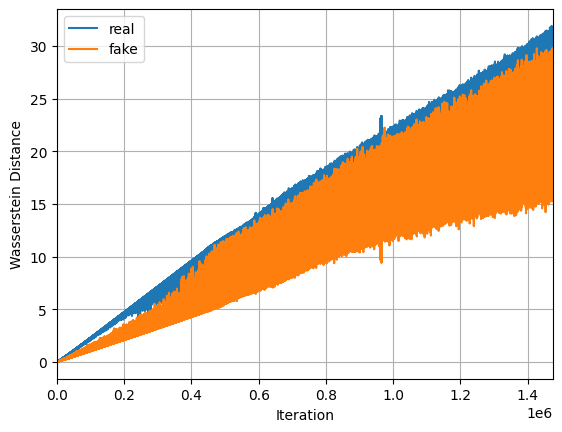

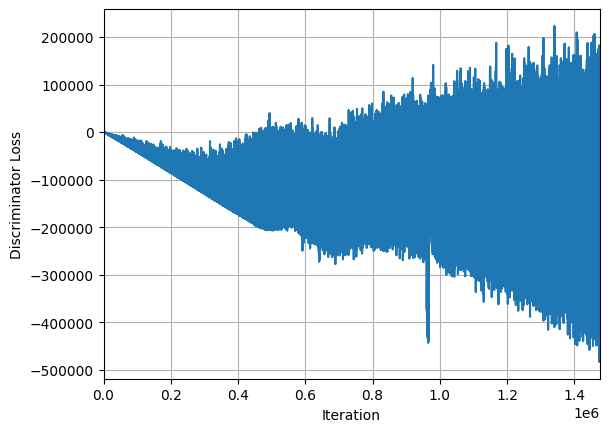

In [58]:
#Train model
model.fit(trX, trY)

### **Generate Data**

/tmp/ipykernel_34/1004838547.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


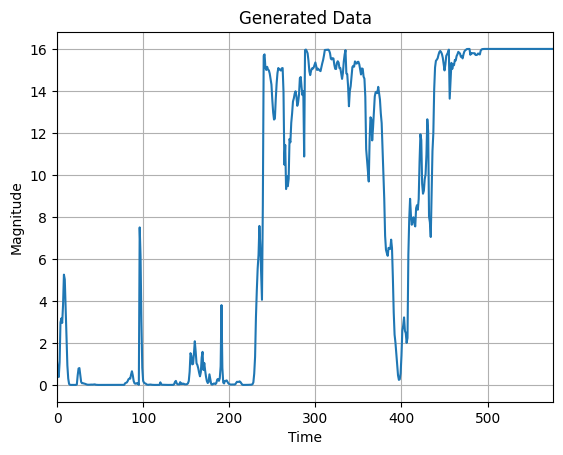

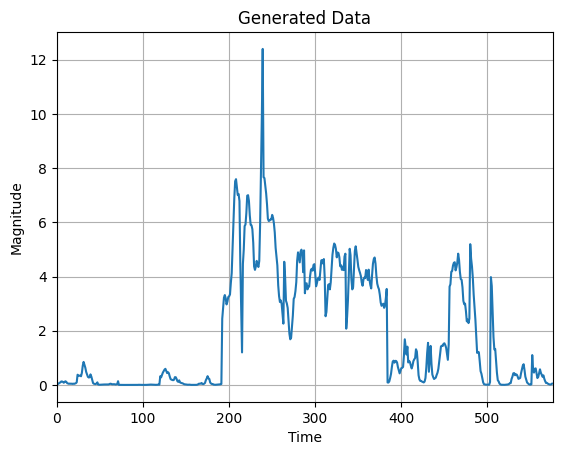

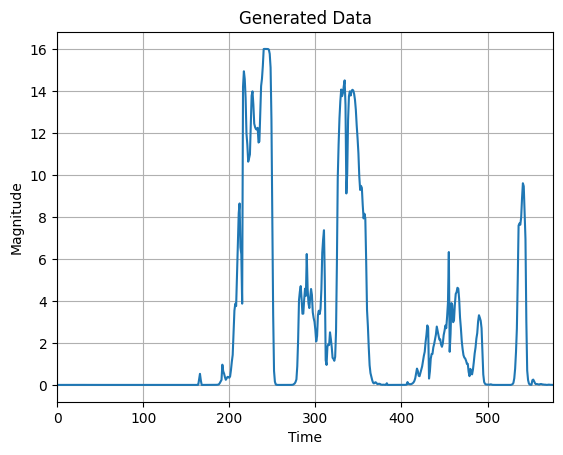

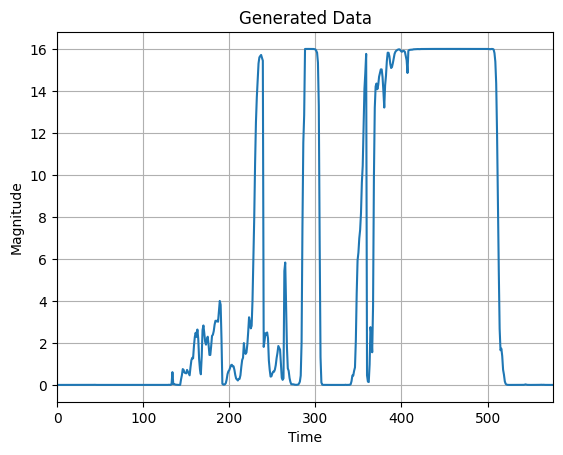

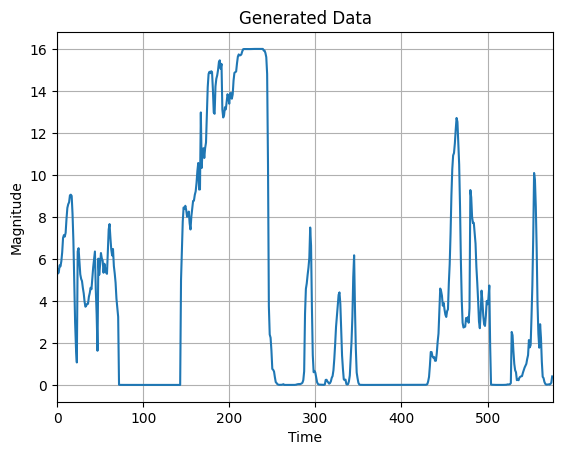

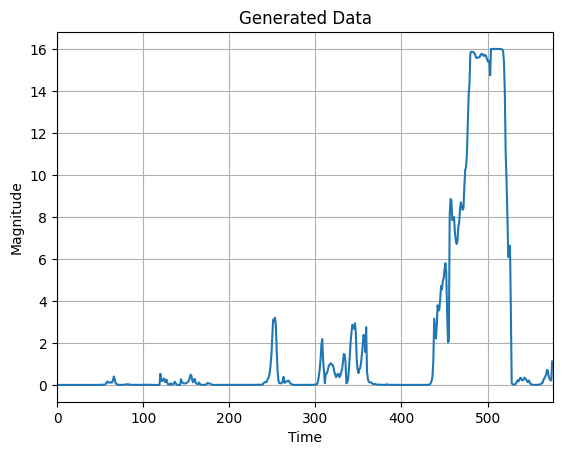

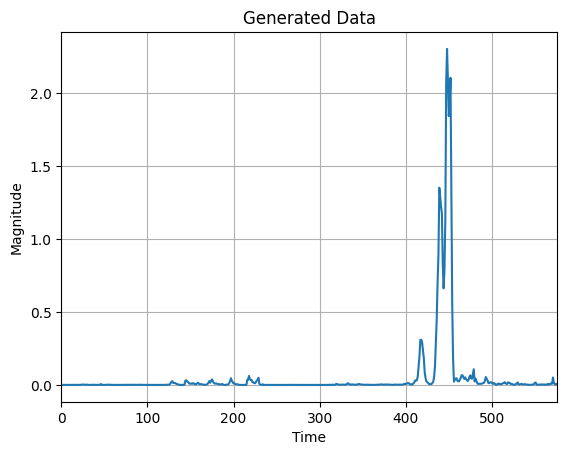

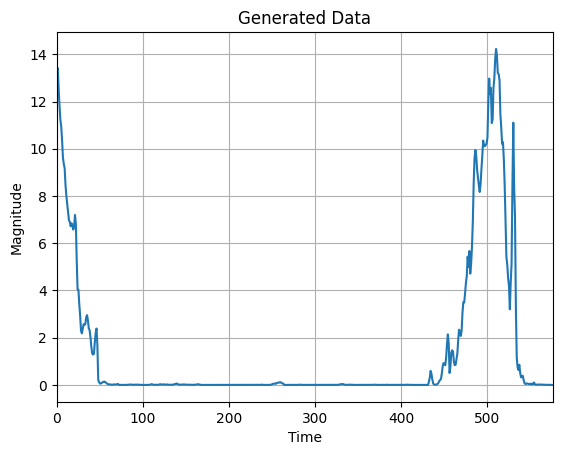

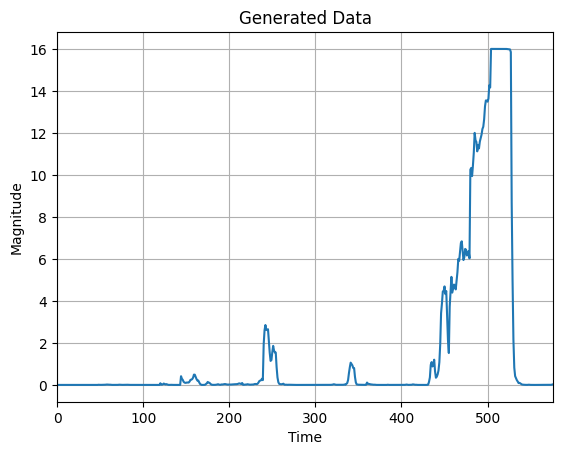

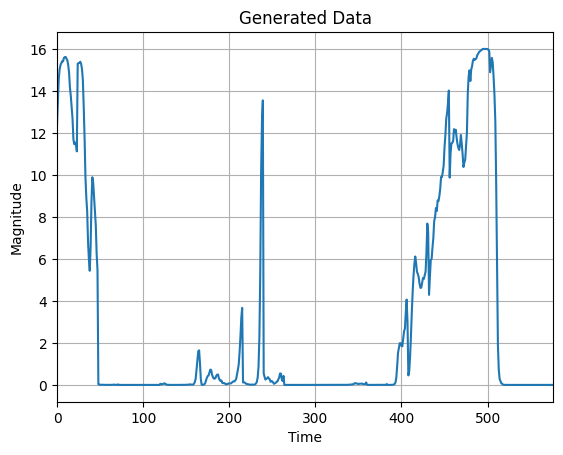

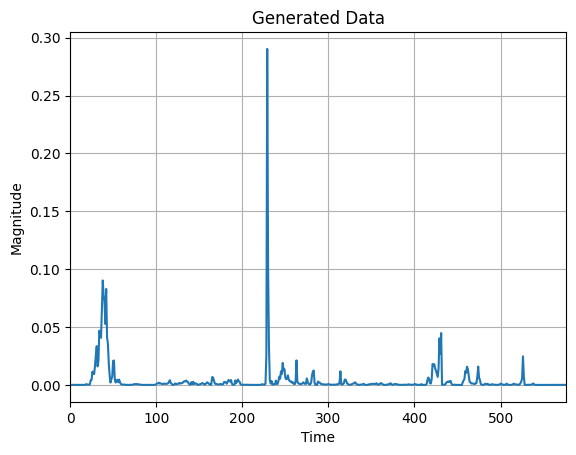

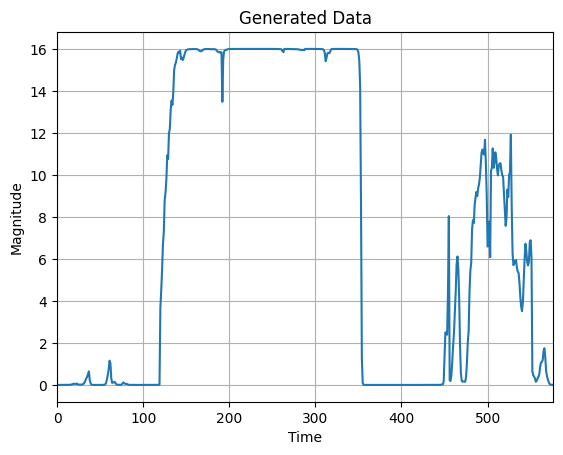

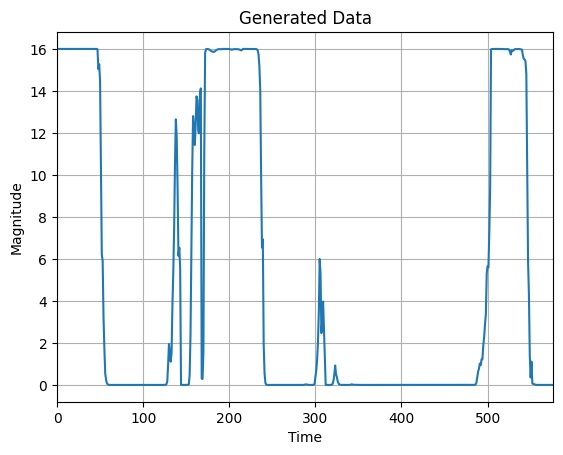

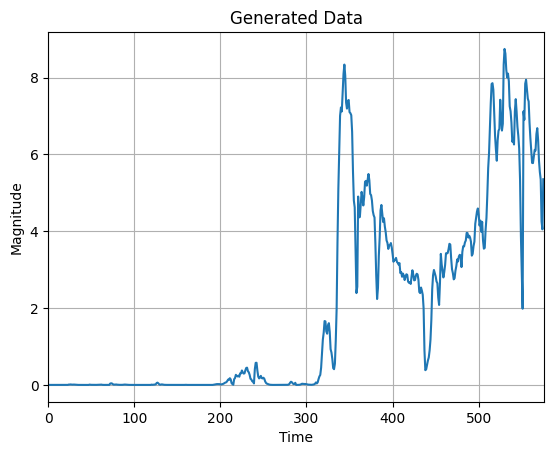

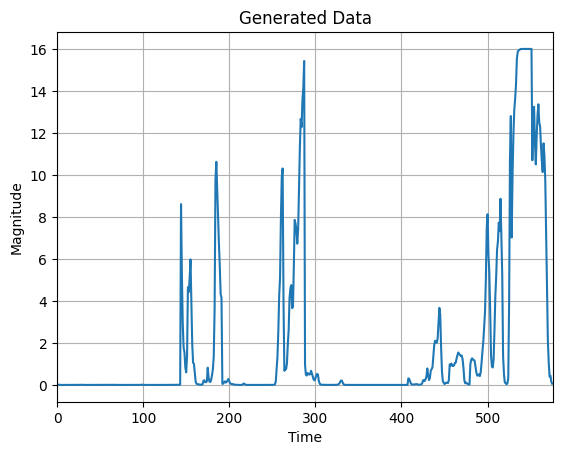

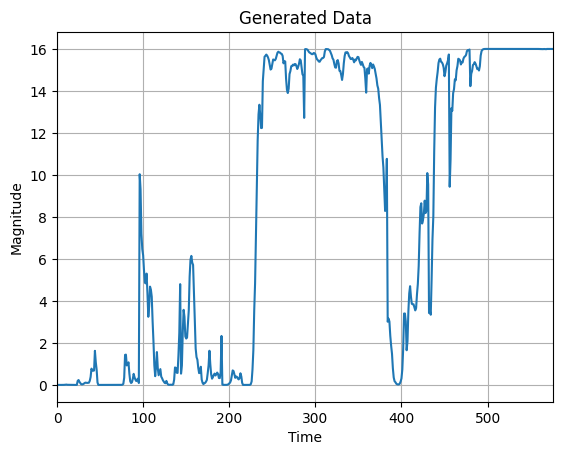

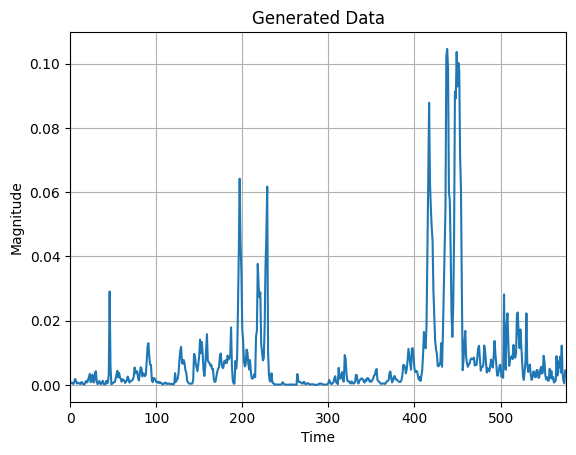

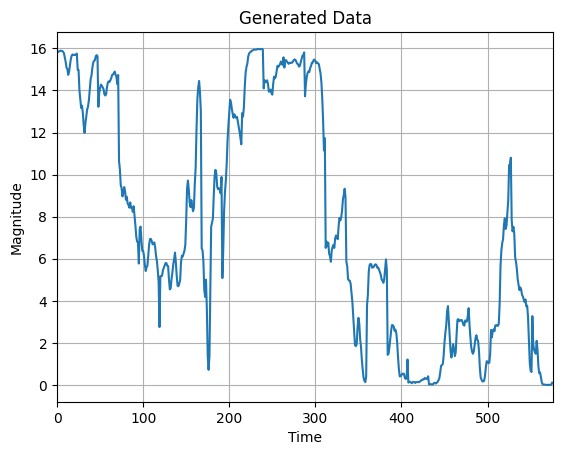

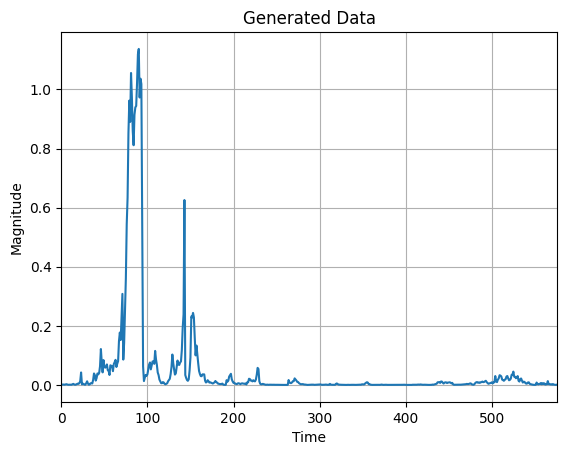

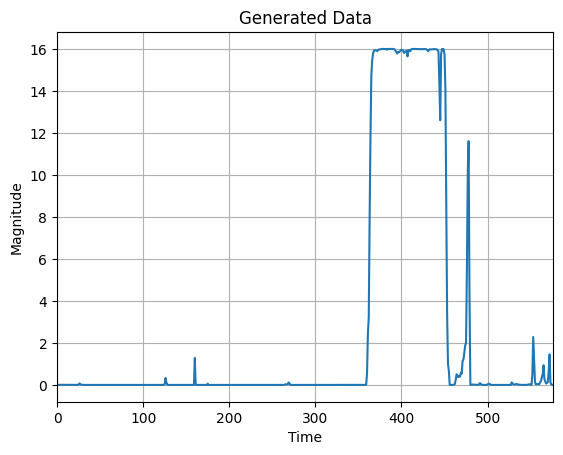

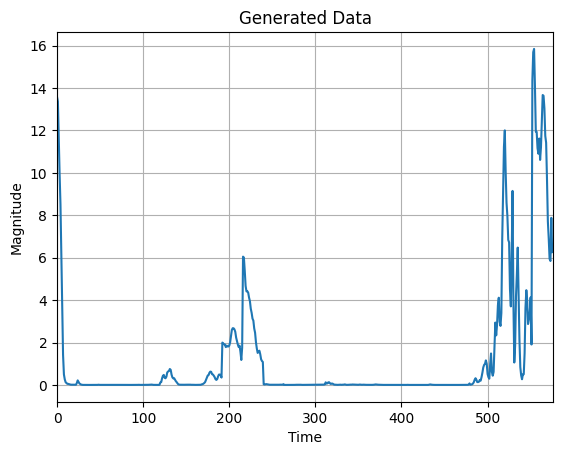

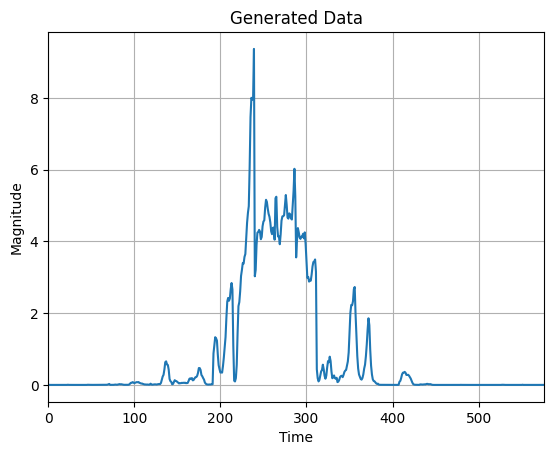

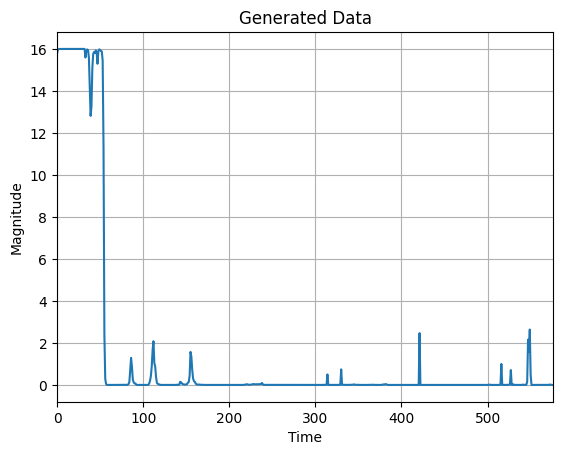

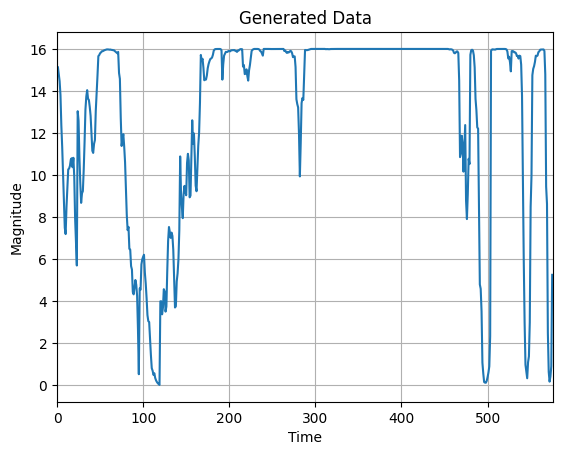

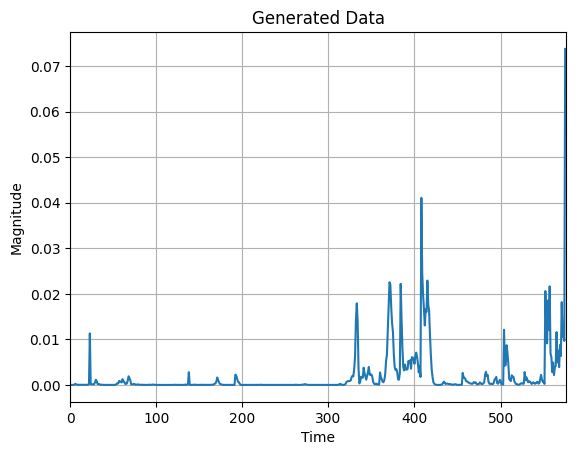

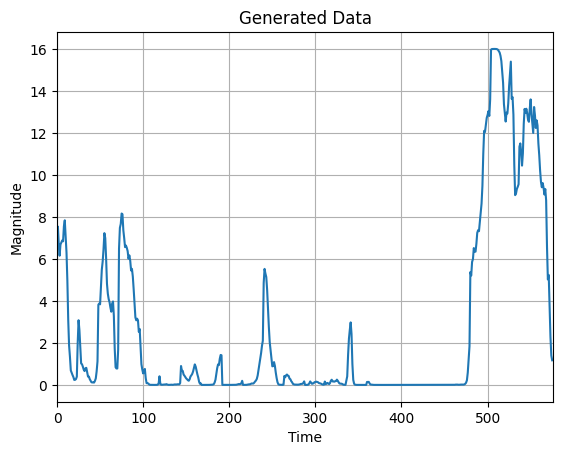

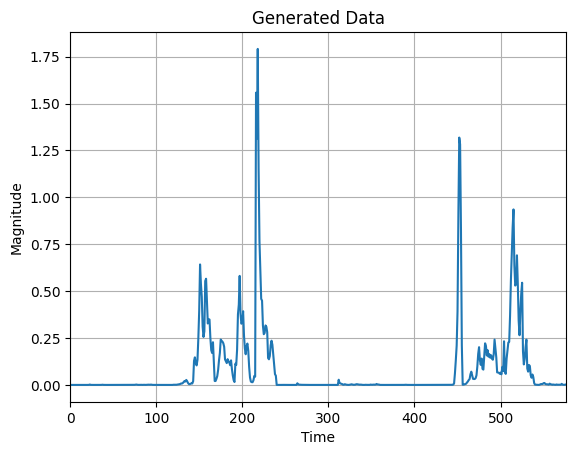

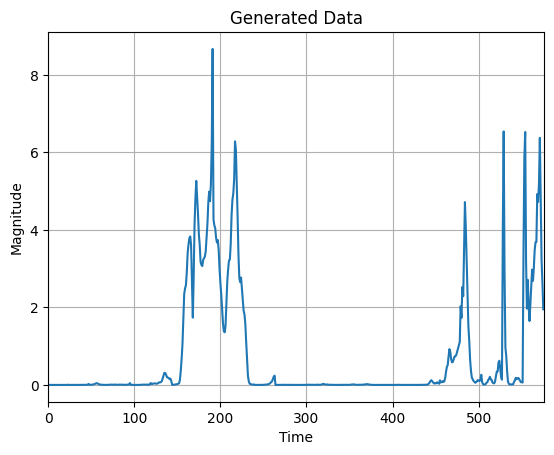

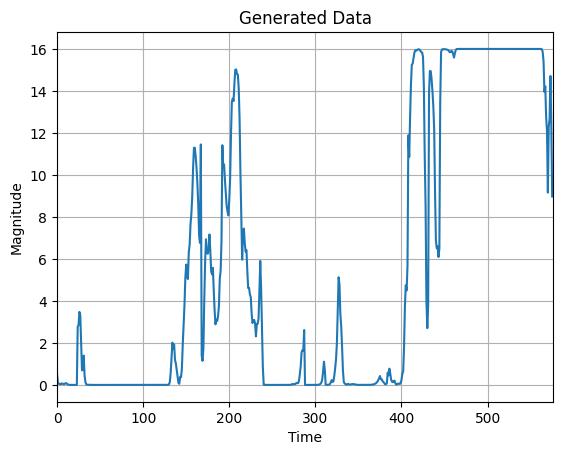

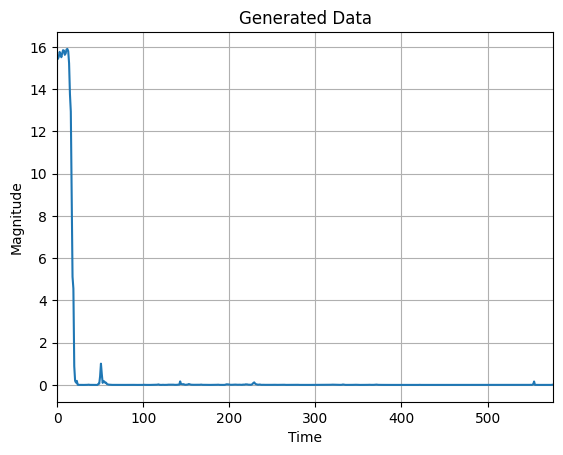

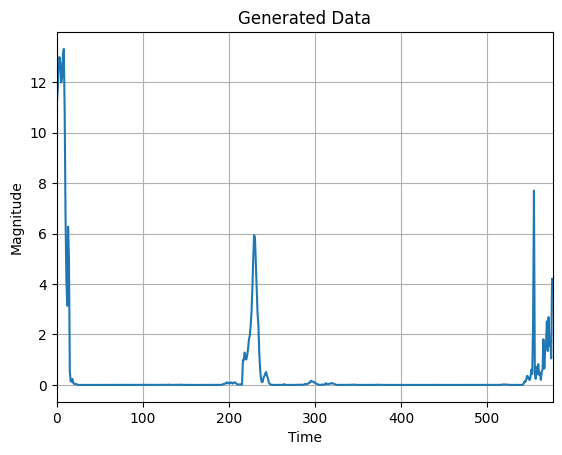

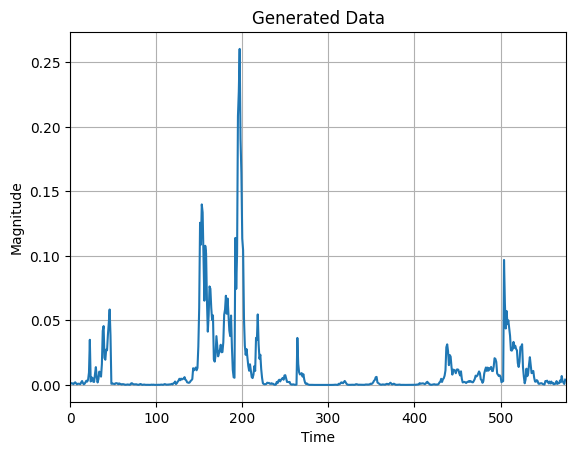

In [59]:
#Sample a set of labels and generate data
data_gen, labels_sampled = model.predict()

#Rescaling
data_gen = data_gen*m

#Depict generated data
for i in range(len(data_gen)):
    fig, ax = plt.subplots()
    ax.plot(data_gen[i,:])
    ax.set_xlim(0, data_gen.shape[-1])
    ax.set_xlabel('Time')
    ax.set_ylabel('Magnitude')
    ax.set_title('Generated Data')
    ax.grid(True)
    fig.show()